In [1]:
import pixiedust
#!pip install --upgrade ~/Development/repos/quantutils
#!pip install --upgrade ~/Development/repos/tradeframework


# import utilities
from quantutils.api.datasource import MarketDataStore
from quantutils.api.auth import CredentialsStore
import quantutils.dataset.pipeline as ppl

#import tradeframework
from tradeframework.api import Derivative, Optimizer, Model, TradeEnvironment, TradeEngine, Asset
from tradeframework.environments import SandboxEnvironment, ZiplineEnvironment
from tradeframework.models import PreOpenMomentum
import tradeframework.utils.trader as trader

# Development
import pandas as pd
import numpy as np


%matplotlib inline

Pixiedust database opened successfully


Processing /home/cwilkin/Development/repos/quantutils
  Created wheel for quantutils: filename=quantutils-1.0.0-py3-none-any.whl size=28603 sha256=faac126d20dd5724daa215fcc060c716da32fd6915832f05c1d738f6debd73d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-0grcig6l/wheels/a1/ee/01/ed970b0d78c74b7e3103a650d2418193504e98f029d8c8916c
Successfully built quantutils
  Attempting uninstall: quantutils
    Found existing installation: quantutils 1.0.0
    Uninstalling quantutils-1.0.0:
      Successfully uninstalled quantutils-1.0.0


You should consider upgrading via the '/home/cwilkin/Development/anaconda/envs/dev/bin/python -m pip install --upgrade pip' command.
Processing /home/cwilkin/Development/repos/tradeframework


  Created wheel for tradeframework: filename=tradeframework-1.0.0-py3-none-any.whl size=19912 sha256=1ab6e757839a672757fba33e6381b317214137f5f88da3486c3a197b4220fe4d
  Stored in directory: /tmp/pip-ephem-wheel-cache-6kellefq/wheels/cd/32/a1/a8c2e3a15d787df32664b93c9905578d63f6a1505878f20b22
Successfully built tradeframework
  Attempting uninstall: tradeframework
    Found existing installation: tradeframework 1.0.0
    Uninstalling tradeframework-1.0.0:
      Successfully uninstalled tradeframework-1.0.0
You should consider upgrading via the '/home/cwilkin/Development/anaconda/envs/dev/bin/python -m pip install --upgrade pip' command.


/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'
/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [23]:
#%%pixie_debugger
ts = pd.read_csv('testDOW.csv', parse_dates=True, index_col=0, dayfirst=True)
ts = ts.tz_localize("UCT")
ts.index = ts.index.tz_convert("US/Eastern")
asset1 = Asset("DOW", ts)

TRAINING_RUN_ID = "94b227b9d7b22c920333aa36d23669c8"
DATASET_ID = "4234f0f1b6fcc17f6458696a6cdf5101"

# Calculate returns via TradeFramework
env = SandboxEnvironment("TradeFair")
p = env.createPortfolio("MyPortfolio", optimizer=env.createOptimizer("EqualWeightsOptimizer", "EqualWeights"))
p.addModel(env.createModel( "MIBasicModel", "Test-MIBasicModel", args=(CredentialsStore(), DATASET_ID, TRAINING_RUN_ID, 0, False, False)))

# Extract 3pm indices
#crop = ppl.cropTime(asset1.values, "15:00", "16:00")
#idx = [asset1.values.index.get_loc(crop.index[x]) for x in range(len(crop))]
idx = [19, 42, 44, 67, 90]

c = 0
for i in idx:
    env.append(Asset("DOW", asset1.values[c:i]))
    env.append(Asset("DOW", asset1.values[i:i+1]))
    c = i+1
env.append(Asset("DOW", asset1.values[c:]))

# Calculate returns manually
np.prod(trader.getPeriodReturns(p.returns)+1)

0.9941924543457394

In [22]:
idx = [19, 42, 44, 67, 90]

[19, 43, 67, 90]

In [29]:
## Get Market Data

mds = MarketDataStore("../../../marketinsights-data/datasources")

assets = {
    "markets": ["DOW"],
    "start": "2016-07-06",
    "end": "2016-07-11"
}

#assets = {
#    "markets": ["DOW"],
#    "start": "2013-01-01",
#    "end": "2018-08-01"
#}

markets = mds.loadMarketData(assets, "H")
ts = ppl.removeNaNs(markets["DOW"])
ts.index = ts.index.tz_convert("US/Eastern")

Loading DOW data from WallSt-hourly in tradefair.hdf
Resampling to H periods
Resampling to H periods
Resampling to H periods
Merging data...
Loading DOW data from D&J-IND in finam.hdf
Resampling to 5min periods
Resampling to H periods
Resampling to H periods
Merging data...


In [ ]:
import quantutils.core.timeseries as tsUtils
import tradeframework.utils.trader as trader

class TwoStdDev(Model):
    def __init__(self, name, env, start=None, end=None):
        Model.__init__(self, name, env)
        self.start = start
        self.end = end
        self.env
        return
    
    def getSignals(self, context, assetInfo):
        
        signals = pd.DataFrame(np.zeros((len(assetInfo.values), 2)), index=assetInfo.values.index, columns=["bar","gap"])
        
        ret =  np.log((trader.getPeriodReturns(assetInfo.returns) + 1))
        
        ma = pd.DataFrame(tsUtils.MA(ret, 20, 10), ret.index)
        std = pd.DataFrame(tsUtils.MStd(ret, 20, 10), ret.index)
        b1 = ma + 2*std
        b2 = ma - 2*std
        
        signals["bar"][(ret > b1[0]) | (ret<b2[0])] = np.sign(ret[(ret > b1[0]) | (ret<b2[0])])
        signals = signals.shift(1)
        signals.iloc[0] = 0
        
        return signals

In [18]:
#%%pixie_debugger
bEnv = SandboxEnvironment("TradeFair")
b = bEnv.createPortfolio("Baseline", optimizer=bEnv.createOptimizer("EqualWeightsOptimizer", "EqualWeights"))
b.addModel(bEnv.createModel( "BuyAndHold", "D3-BuyAndHold", args=("15:00", "16:00", True)))
#p.addModel(MeanReversion("MR-BL", bEnv, "12:00", "13:00" ))
#p.addModel(bEnv.createModel( "BuyAndHold", "D3-BuyAndHold"))
baseline = bEnv.append(Asset("DOW", ts)).assets[0]

In [19]:
env = SandboxEnvironment("TradeFair")

#opt = env.createOptimizer("KellyOptimizer", "KellyOpt", opts={"window":20*24, "weight":.05})
opt = env.createOptimizer("EqualWeightsOptimizer", "EqualWeights")#, opts={"weight":4.0})
p = env.createPortfolio("MyPortfolio", optimizer=opt)

#p.addModel(RetraceDailyMove("RDM1", env, "12:00", "13:00" ))
#p.addModel(RetraceDailyMove("RDM2", env, "13:00", "14:00" ))
#p.addModel(RetraceDailyMove("RDM3", env, "14:00", "15:00" ))
#p.addModel(RetraceDailyMove("RDM4", env, "15:00", "16:00" ))

#p.addModel(env.createModel( "MeanReversion", "MR1", args=("15:00", "16:00" )))
#p.addModel(MeanReversion("MR2", env, "10:00", "11:00" ))
#p.addModel(MeanReversion("MR3", env, "11:00", "12:00" ))
#p.addModel(MeanReversion("MR4", env, "12:00", "13:00" ))
#p.addModel(MeanReversion("MR5", env, "13:00", "14:00" ))
#p.addModel(MeanReversion("MR6", env, "14:00", "15:00" ))
#p.addModel(env.createModel("MeanReversion", "MR7", args=("15:00", "16:00", True)))
p.addModel(env.createModel("TrendFollowing", "TF7", args=("15:00", "16:00", True)))
#p.addModel(TwoStdDev("SD", env))

#p.addModel(env.createModel( "PreOpenMomentum", "D1-PreOpenMomentum" ))

#p.addModel(env.createModel( "BuyAndHold", "D2-BuyAndHold" ))

#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold7", args=("09:00", "10:00")))
#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold6", args=("10:00", "11:00")))
#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold5", args=("11:00", "12:00")))
#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold4", args=("12:00", "13:00")))
#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold3", args=("13:00", "14:00")))
#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold2", args=("14:00", "15:00")))
#p.addModel(env.createModel( "BuyAndHold", "D3-BuyAndHold1", args=("15:00", "16:00")))

#p.addModel(env.createModel( "SellAndHold", "D4-SellAndHold", args=("15:00", "16:00")))
threshold = 0
#p.addModel(env.createModel( "MIBasicModel", "ML-BasicBootstrap_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', '4892e256e17f4fad775119304ee7e6d1', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-BasicBootstrap_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', '4892e256e17f4fad775119304ee7e6d1', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-BasicBoosting_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', '83c0ff9eeb24c87dbb0af766ab59ef75', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-BasicBoosting_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', '83c0ff9eeb24c87dbb0af766ab59ef75', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-OneStepAhead_Boosting_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', 'f2efe64bbc39ad0880337120f32ca12b', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-OneStepAhead_Boosting_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', 'f2efe64bbc39ad0880337120f32ca12b', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-OneStepAhead_Bootstrap_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', '078df5a1afbaa2290ee93b4a562e3898', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-OneStepAhead_Bootstrap_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', '078df5a1afbaa2290ee93b4a562e3898', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-OneStepAhead_Bootstrap_SwitchedOrder_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', 'bdfa91432d64e63fc528869163a8b3fb', threshold, True)))
#p.addModel(env.createModel( "MIBasicModel", "ML-OneStepAhead_Bootstrap_SwitchedOrder_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', 'bdfa91432d64e63fc528869163a8b3fb', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-OneStepAhead_Boosting_LongRun_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', '9a23dcf38b04cccf8a28381ea013dc7f', threshold)))
#p.addModel(env.createModel( "MIBasicModel", "ML-OneStepAhead_Boosting_LongRun_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', '9a23dcf38b04cccf8a28381ea013dc7f', threshold, True)))

#TODO Aggregate multiple training runs as well as datasets
agg = [{
    'training_run_id': 'bdfa91432d64e63fc528869163a8b3fb',
    'datasets': ['4234f0f1b6fcc17f6458696a6cdf5101', '3231bbe5eb2ab84eb54c9b64a8dcea55']
}]

#p.addModel(env.createModel( "MIAggregateModel", "ML-OneStepAhead_Agg", args=(CredentialsStore(), agg, "vote_unanimous_all", threshold)))

# Feed data into the portfolio
#for index in range(0, len(ts)):
#env.handleData(0, ts[:index+1])
env.append(Asset("DOW", ts)) 
print("Done")

Done


(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f54ac805550>)

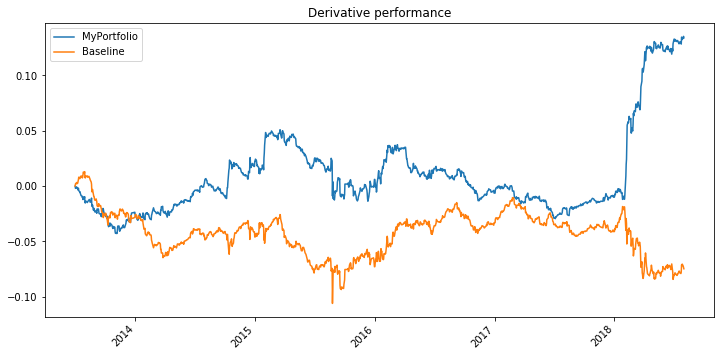

In [21]:
# MODEL: p.addModel(env.createModel("TrendFollowing", "TF7", args=("15:00", "16:00", True)))
#
# TODO - Notice how the simple trend following model works well when the market volatility changes in 2018. A 
# property of the market "stretching" so that the medium term (in this case bi-hourly) trends hit their sweet spot. 
# Earlier when volatility is lower and market is "compacted", the target trend term is longer (maybe 4-hourly). This 
# could be achieved with a MA with a dynamic window, or by dynamically modifying the time sample sizes. 

# TODO - The visualisation of the basline is misleading and does not show the cause of the performance (in this case the
# previous hours prices and the current hours prices, in a sequentional form). Perhaps we need to show period returns
# rather than daily returns (which is what getPeriodReturns provides)

trader.plot(p, baseline, includeComponents=False, includePrimary=True, log=True)

(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2a4effa0f0>)

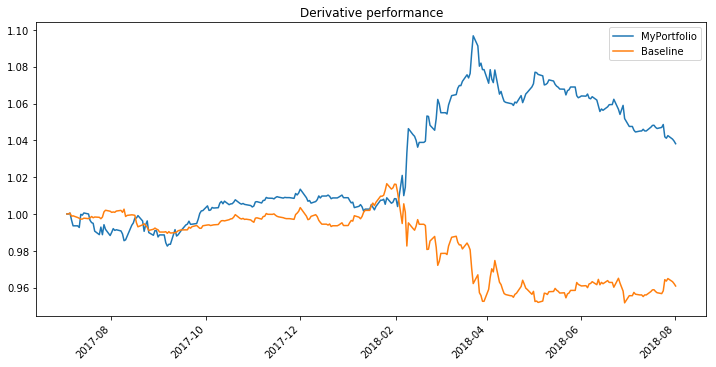

In [11]:
# TODO - EVEN MORE SUSPICIOUS PLOT - Why are Multiple Equally Weight MI signals generating the exact inverse of the baseline
# Sell signal until training period over (2000ish training set)?

import tradeframework.utils.trader as trader
#tInfo = env.getTradingInfo(context, dInfo, 10000)
trader.plot(p, baseline, includeComponents=False, includePrimary=True, log=False)

In [10]:
## import tradeframework.utils.trader as trader
tInfo = env.getTradingInfo(context, dInfo, 10000)
#fig, ax = trader.plot(dInfo.assets[0], includeComponents=False, includePrimary=False, log=False)

# Add Moving Average
import quantutils.core.timeseries as tsUtils
period = 20
offset = 10
ret =  np.log((trader.getPeriodReturns(baseline.assets[0].returns) + 1))

ma2 = pd.DataFrame(tsUtils.MA(np.cumsum(ret), period, offset), np.cumsum(ret).index)

ma1 = pd.DataFrame(tsUtils.MA(ret, period, offset), ret.index)
ma1.iloc[int(np.ceil(period/2+offset)-1)] =  np.cumsum(ma2).iloc[int(np.ceil(period/2+offset)-1)]

ma3 = pd.DataFrame(EMA(ret, period, offset), ret.index)
ma3.iloc[int(np.ceil(period/2+offset)-1)] = np.cumsum(ma2).iloc[int(np.ceil(period/2+offset)-1)]

# Bollinger Bands
b1 = ma1 + 2*pd.DataFrame(MStd(ret, period, offset), ret.index)
b2 = ma1 - 2*pd.DataFrame(MStd(ret, period, offset), ret.index)

#ax.plot(np.cumsum(ma1), label="MA=20")
#ax.plot(np.cumsum(ma2), 'ro', label="MA=20")
#ax.plot(np.cumsum(ma3), label="EMA=20")
#ax.plot(np.cumsum(ret),label="Return")
#ax.plot(np.cumsum(b1),label="Upper",color='b')
#ax.plot(np.cumsum(b2),label="Lower",color='b')
ax.plot(ret,label="Return")
ax.plot(ma1, label="MA=20")
ax.plot(b1,label="Upper",color='b')
ax.plot(b2,label="Lower",color='b')

signals = pd.DataFrame(np.zeros((len(baseline.assets[0].returns), 2)), index=baseline.assets[0].returns.index, columns=["bar","gap"])
signals["bar"][(ret > b1[0]) | (ret<b2[0])] = np.negative(np.sign(ret[(ret > b1[0]) | (ret<b2[0])]))
signals = signals.shift(1)
signals.iloc[0] = 0
print(signals[:10])

ax.legend(loc='best')
fig.canvas.draw()

/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/quantutils/core/timeseries.py:5: FutureWarning: Series.strides is deprecated and will be removed in a future version
  strides = a.strides + (a.strides[-1],)


NameError: name 'MStd' is not defined

In [171]:
s[(ret > b1[0]) | (ret<b2[0])] = ret[(ret > b1[0]) | (ret<b2[0])]
s[(ret > b1[0]) | (ret<b2[0])][:10]

Date_Time
2016-07-06 11:00:00-04:00   -0.0028989199
2016-07-06 12:00:00-04:00   -0.0027498755
2016-07-07 15:00:00-04:00    0.0038070757
2016-07-08 08:00:00-04:00   -0.0042140577
2016-07-10 22:00:00-04:00    0.0036564117
2016-07-12 04:00:00-04:00    0.0022138113
2016-07-12 11:00:00-04:00    0.0020186596
2016-07-13 09:00:00-04:00    0.0021459527
2016-07-14 02:00:00-04:00   -0.0041677510
2016-07-14 05:00:00-04:00    0.0036714130
Name: bar, dtype: float64

In [173]:
ret[(ret > b1[0]) | (ret<b2[0])][:10]

Date_Time
2016-07-06 11:00:00-04:00   -0.0028989199
2016-07-06 12:00:00-04:00   -0.0027498755
2016-07-07 15:00:00-04:00    0.0038070757
2016-07-08 08:00:00-04:00   -0.0042140577
2016-07-10 22:00:00-04:00    0.0036564117
2016-07-12 04:00:00-04:00    0.0022138113
2016-07-12 11:00:00-04:00    0.0020186596
2016-07-13 09:00:00-04:00    0.0021459527
2016-07-14 02:00:00-04:00   -0.0041677510
2016-07-14 05:00:00-04:00    0.0036714130
dtype: float64

/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/quantutils/core/timeseries.py:12: RuntimeWarning: invalid value encountered in multiply
  r = np.empty(len(values)) * np.nan


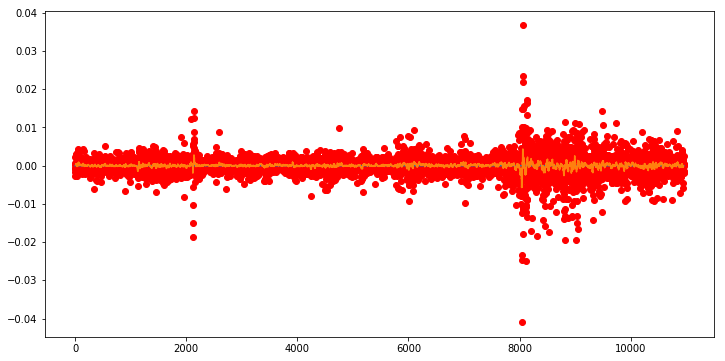

In [48]:
# Returns plot
from matplotlib import pyplot
x = np.diff(tInfo.values[:,0]/10000)
ma = tsUtils.MA(x, 20)
pyplot.plot(x,'ro')
pyplot.plot([0] * len(x))
pyplot.plot(ma)
pyplot.show()

/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/quantutils/core/timeseries.py:12: RuntimeWarning: invalid value encountered in multiply
  r = np.empty(len(values)) * np.nan


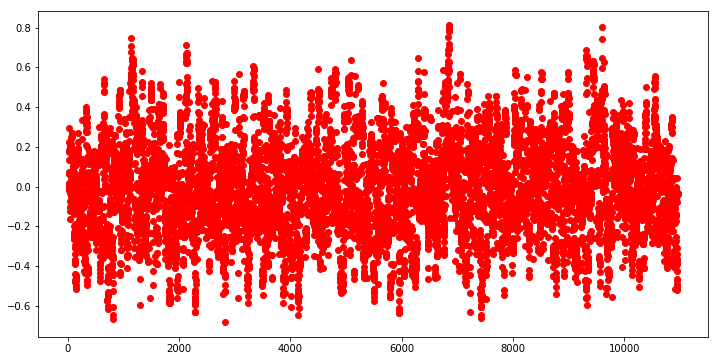

In [49]:
# Moving ACF plot
pyplot.plot(tsUtils.MACF(x, 1, 20, 10), 'ro')
pyplot.show()

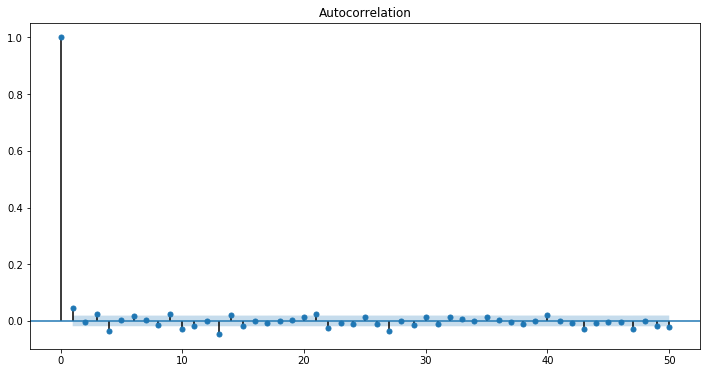

(-21.657623155825704,
 0.0,
 26,
 10932,
 {'1%': -3.430948320175338,
  '5%': -2.861804424408925,
  '10%': -2.566910747983175},
 -109835.06372657401)

In [36]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
plot_acf(x, lags=50)
pyplot.show()
adfuller(x)

In [37]:
import statsmodels.api as sm

# Fit the model
#x = x - x.mean()
mod_data = sm.tsa.MarkovAutoregression(x, k_regimes=2, order=1, trend='nc', switching_variance=True)
res_data = mod_data.fit()

res_data.summary()

/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/numpy/linalg/linalg.py:1728: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/scipy/stats/

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                     Open   No. Observations:                10958
Model:             MarkovAutoregression   Log Likelihood                     nan
Date:                  Thu, 16 Aug 2018   AIC                                nan
Time:                          10:56:11   BIC                                nan
Sample:                               0   HQIC                               nan
                                - 10958                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2            nan        nan        nan        nan         nan         nan
ar.L1             nan        nan        nan        nan         nan         nan
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2            nan        nan        nan        nan         nan         nan
ar.L1             nan        nan        nan        nan         nan         nan
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]           nan        nan        nan        nan         nan         nan
p[1->0]           nan        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, figsize=(10,7))

bInfo = bEnv.getTradingInfo(context, baseline, startCapital=1)
ax = axes[0]
ax.plot(bInfo.values[:,0])
ax.set(title='MR Strategy')

ax = axes[1]
ax.plot(tInfo.values[:,0]/10000)
ax.set(title='Market')

ax = axes[2]
ax.plot(x, 'ro')
ax.set(title='Returns')

ax = axes[3]
ax.plot(res_data.filtered_marginal_probabilities[0])
ax.set(title='Smoothed probability of a Momentum regime')

ax = axes[4]
ax.plot(res_data.filtered_marginal_probabilities[1])
ax.set(title='Smoothed probability of a Mean Reversion regime')

#ax = axes[4]
#ax.plot(res_data.filtered_marginal_probabilities[2])
#ax.set(title='Smoothed probability of a High Mean Reversion regime')

fig.tight_layout()

In [7]:
from tradeframework.api import Model

asset1 = Asset("DOW", pd.read_csv('../unittest/data/testData1.csv', parse_dates=True, index_col=0, dayfirst=True))

randomSignals = np.array([1, 1, 0, -1, 0, -1, 1, -1, 0])

class RandomModel(Model):

    def getSignals(self, asset):
        signals = pd.DataFrame(np.array([np.zeros(len(asset.values)), randomSignals[:len(asset.values)]]).T, index=asset.values.index, columns=["bar", "gap"])
        return signals

# Calculate returns via TradeFramework
env = SandboxEnvironment("TradeFair")
p = env.createPortfolio("MyPortfolio", optimizer=env.createOptimizer("EqualWeightsOptimizer", "EqualWeights"))
p.addModel(RandomModel("SellAndHold", env))

for i in range(len(asset1.values)):
    x = env.append(Asset("DOW", asset1.values[i:i + 1]))

# Calculate returns manually
mRet = randomSignals[:-1] * np.diff(asset1.values["Close"]) / asset1.values["Close"][:-1]

np.allclose(p.returns.values[:, 1][:-1], mRet.values)

True

In [5]:
p.returns

,Open,Close
Date,,
2018-01-01,0.0,-0.2
2018-01-02,0.0,0.1
2018-01-03,0.0,0.0
2018-01-04,0.0,-0.1
2018-01-05,0.0,0.0
2018-01-06,0.0,-0.1
2018-01-07,0.0,-0.2
2018-01-08,0.0,-0.1
2018-01-09,0.0,0.0


In [17]:
p.assets[0].values

,Open,Close
Date,,
2018-01-01,1.000000,1.000000
2018-01-02,0.800000,0.800000
2018-01-03,0.880000,0.880000
2018-01-04,0.880000,0.880000
2018-01-05,0.792000,0.792000
2018-01-06,0.792000,0.792000
2018-01-07,0.712800,0.712800
2018-01-08,0.570240,0.570240
2018-01-09,0.513216,0.513216


In [18]:
asset1.values

,Open,Close
Date,,
2018-01-01,100.000000,100.000000
2018-01-02,80.000000,80.000000
2018-01-03,88.000000,88.000000
2018-01-04,70.400000,70.400000
2018-01-05,77.440000,77.440000
2018-01-06,61.952000,61.952000
2018-01-07,68.147200,68.147200
2018-01-08,54.517760,54.517760
2018-01-09,59.969536,59.969536
